# Day 2 - Embeddings and Similarity Scores with LlamaIndex

Welcome back to the 5-day Generative AI course! In this notebook, we'll explore embeddings and similarity scores using LlamaIndex and Azure OpenAI's embedding models.

## Setup and Initialize

First, let's install the required packages:

```python
%pip install -q llama-index llama-index-core llama-index-embeddings-azure-openai python-dotenv numpy pandas seaborn
```

## Import dependencies and setup

In [1]:
from dotenv import load_dotenv
from llama_index.core import Document
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
import numpy as np
import pandas as pd
import seaborn as sns
import os
from typing import List

## Configure Azure OpenAI credentials

Create `.env` file with the following content:

```
AZURE_OPENAI_ENDPOINT="YOUR_AZURE_ENDPOINT"
AZURE_OPENAI_KEY="YOUR_API_KEY"
OPENAI_API_VERSION="YOUR_API_VERSION"
```

In [2]:
os.getenv('AZURE_OPENAI_ENDPOINT')

In [3]:
load_dotenv()

embedding_model = AzureOpenAIEmbedding(
    model= 'text-embedding-ada-002',
    azure_deployment = 'text-embedding-ada-002',
    api_key = os.getenv("AZURE_OPENAI_KEY"),
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version = '2023-05-15'
    )

## Introduction to Text Embeddings and Similarity

**Text embeddings** are dense vector representations of text in high-dimensional space. Each dimension captures some semantic aspect of the text, allowing us to:

- Represent text mathematically
- Compare texts using vector operations
- Capture semantic relationships

A similarity score of two embedding vectors can be obtained by calculating the cosine similarity between them. As those embeddin vectors are normalized to unit length, this is also the dot product of the vectors.

This score can be computed across all embeddings through the matrix self-multiplication: `df @ df.T`.

Note that the range from 0.0 (completely dissimilar) to 1.0 (completely similar) is depicted in the heatmap from dark (0.0) to light (1.0).

### Calcuate similarity scores

This example embeds some variations on the pangram, `The quick brown fox jumps over the lazy dog`, including spelling mistakes and shortenings of the phrase. Another pangram and a somewhat unrelated phrase have been included for comparison.

Define a shorter helper fucntion that will make it easier to display longer embedding texts in the visualization

In [4]:
def truncate_text(t: str, max_len: int = 50) -> str:
    if len(t) > max_len:
        return t[:max_len-3] + "..."
    return t

In [5]:
texts = [
    'The quick brown fox jumps over the lazy dog.',
    'The quick rbown fox jumps over the lazy dog.',
    'teh fast fox jumps over the slow woofer.',
    'a quick brown fox jmps over lazy dog.',
    'brown fox jumping over dog',
    'fox > dog',
    # Alternative pangram for comparison:
    'The five boxing wizards jump quickly.',
    # Unrelated text, also for comparison:
    'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus et hendrerit massa. Sed pulvinar, nisi a lobortis sagittis, neque risus gravida dolor, in porta dui odio vel purus.',
]

trunctated_texts = [truncate_text(t) for t in texts]


# get the embeddings
embeddings = [embedding_model.get_text_embedding(text) for text in texts]

# convert to dataframe
df = pd.DataFrame(embeddings, index = trunctated_texts)

# calculate the similarity matrix
sim = df @ df.T

### Visualize similarities

Create a heatmap showing the similarity scores between all pairs of text samples. 

<Axes: >

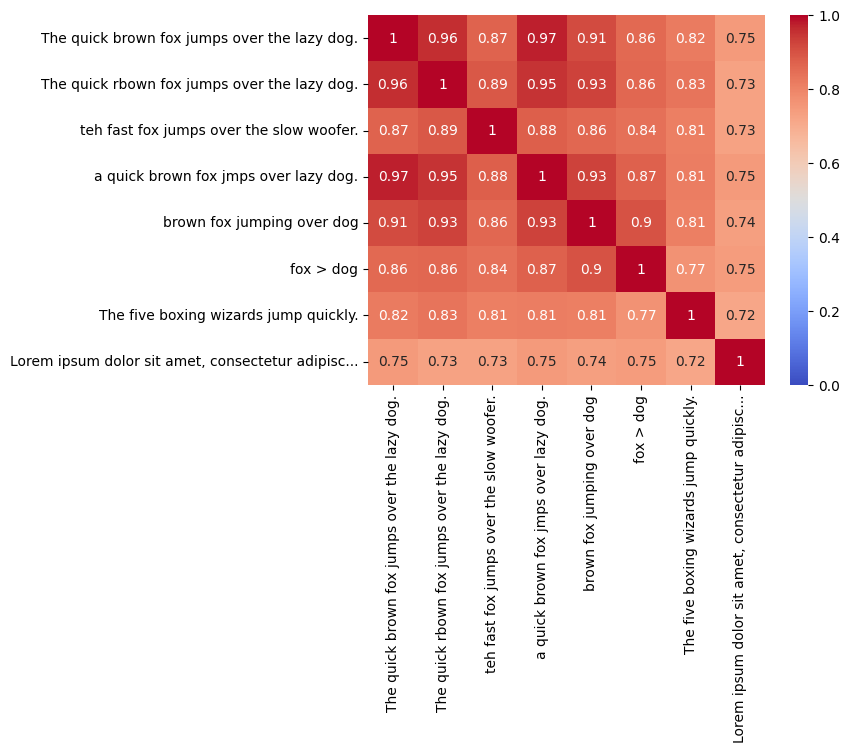

In [6]:
sns.heatmap(sim, vmin=0, vmax=1, annot=True, cmap='coolwarm')

In [7]:
# Get similarities to the original text
sim['The quick brown fox jumps over the lazy dog.'].sort_values(ascending=False)

The quick brown fox jumps over the lazy dog.          1.000000
a quick brown fox jmps over lazy dog.                 0.974152
The quick rbown fox jumps over the lazy dog.          0.958399
brown fox jumping over dog                            0.912541
teh fast fox jumps over the slow woofer.              0.867575
fox > dog                                             0.857386
The five boxing wizards jump quickly.                 0.818168
Lorem ipsum dolor sit amet, consectetur adipisc...    0.749961
Name: The quick brown fox jumps over the lazy dog., dtype: float64

# Further Reading

## Re-Ranking with Embeddings
Re-ranking is a technique to improve search results by using embeddings to refine initial results. Here's an implementation:

In [8]:
class EmbeddingReRanker:
    def __init__(self, embedding_model):
        self.embedding_model = embedding_model

    def rank_results(self, query: str, candidates: List[str], top_k:int = 5) -> List[str]:
        # get the query embedding
        query_embedding = self.embedding_model.get_text_embedding(query)
        # get the candidate embeddings
        candidate_embeddings = [self.embedding_model.get_text_embedding(candidate) for candidate in candidates]

        # calculate the similarities
        similarities = np.dot(query_embedding, np.array(candidate_embeddings).T)

        # sort by similarity and select the top-k results with the highest similarity
        ranked_results = [candidates[i] for i in np.argsort(similarities)[::-1][:top_k]]
        return ranked_results
    
  
# Example usage
reranker = EmbeddingReRanker(embedding_model)
sample_results = [
    "The quick brown fox jumps",
    "A brown cat sleeping",
    "Quick foxes are agile",
    "Lorem ipsum text"
]

query = "fox jumping"
ranked = reranker.rank_results(query, sample_results)
print("Ranked results:", ranked)

Ranked results: ['Quick foxes are agile', 'The quick brown fox jumps', 'A brown cat sleeping', 'Lorem ipsum text']


## Anomaly Detection Using Embeddings

Embeddings can be used to detect anomalous or outlier texts. We will use three common methods for anomaly detection:

- Dimensionality reduction: PCA
- Clustering: K-means
- Isolation Forecast

### PCA

Principal Component Analysis (PCA) is commonly used to reduce high-dimensional embeddings while preserving important variations. Anomalies can be detected by:
- Measuring reconstruction error
- Looking at distance in reduced space


Mathematical Intuition:

PCA finds principal components that maximize variance
Reconstruction error = $||x - \hat{x}||^2$ where: $x$ is original data\, and $\hat{x}$ is PCA reconstruction

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def detect_anomalies_pca(texts: List[str],
                         embedding_model,
                         n_components: int = 2,
                         threshold: float = 2.0) -> List[str]:
    """Detect anomalies using PCA reconstruction error."""
    text_embeddings = np.array([
        embedding_model.get_text_embedding(text) for text in texts 
    ])

    # Standardize the embeddings
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(text_embeddings)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(scaled_embeddings)

    # reconstruct the data
    resconstructed = pca.inverse_transform(pca_results)

    # calculate the reconstruction error
    resconstructed_error = np.linalg.norm(scaled_embeddings - resconstructed, axis=1)

    # normalize the error
    z_scores = (resconstructed_error - np.mean(resconstructed_error)) / np.std(resconstructed_error)

    # detect anomalies index
    anomalies = np.where(z_scores > threshold)[0]

    return anomalies, resconstructed_error, z_scores

# Example usage
texts = [
    "This is a normal sentence about cats",
    "Another regular text about dogs",
    "!@#$ completely random 12345 garbage",
    "Normal description about animals",
    "x7v1m4 weird text $#@!",
]

anomalies, errors, z_scores = detect_anomalies_pca(texts, embedding_model, n_components=2, threshold=2)
print(f"Anomalies found: {anomalies}")
print(f"Reconstruction errors: {errors}")
print(f"Z-scores: {z_scores}")
    

Anomalies found: []
Reconstruction errors: [26.06780874 17.39602977 20.58964295 27.93154893 25.49570031]
Z-scores: [ 0.65986224 -1.56522727 -0.7457789   1.13807885  0.51306508]


### K-means Clustering

K-Means can identify anomalies by:

- Finding cluster centers
- Measuring distances to nearest center
- Flagging points far from their centers

Mathematical Intuition:

- Points are assigned to nearest cluster center
- Anomaly score = distance to nearest center
- Threshold typically based on distribution of distances

In [10]:
from sklearn.cluster import KMeans

def detect_anomalies_kmeans(texts, embed_model, n_clusters=2, threshold_percentile=95):
    """Detect anomalies using K-means clustering distances."""
    
    # Get embeddings
    embeddings = np.array([
        embed_model.get_text_embedding(text)
        for text in texts
    ])
    
    # Standardize
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    # Fit K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_embeddings)
    
    # Calculate distances to nearest centroid
    distances = kmeans.transform(scaled_embeddings).min(axis=1)
    
    # Find threshold based on percentile
    threshold = np.percentile(distances, threshold_percentile)
    
    # Find anomalies
    anomalies = np.where(distances > threshold)[0]
    
    return anomalies, distances, clusters

# Example usage
anomalies, distances, clusters = detect_anomalies_kmeans(texts, embedding_model)
print(f"Anomalies found at indices: {anomalies}")
print(f"Clusters: {clusters}")

Anomalies found at indices: [1]
Clusters: [0 0 1 0 1]


Compare the anomaly scores using K-means clustering withP PCA-reduced embeddings, K-means results make much more sense

### Isolation Forest

Isolation Forest detects anomalies by measuring how easily a point can be "isolated" using random splits.

Mathematical Intuition:

- Anomalies need fewer splits to isolate
- Anomaly score based on average path length
- Shorter paths = more likely to be anomalous

In [11]:
from sklearn.ensemble import IsolationForest

def detect_anomalies_iforest(texts, embed_model, contamination=0.1, random_state=42):
    """Detect anomalies using Isolation Forest."""
    
    # Get embeddings
    embeddings = np.array([
        embed_model.get_text_embedding(text)
        for text in texts
    ])
    
    # Standardize
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    # Fit Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination, # Expected proportion of anomalies
        random_state=random_state
    )
    
    # Fit and predict
    # -1 for anomalies, 1 for normal points
    predictions = iso_forest.fit_predict(scaled_embeddings)
    
    # Get anomaly scores (-1 to 1, lower = more anomalous)
    scores = iso_forest.score_samples(scaled_embeddings)
    
    # Find anomaly indices
    anomalies = np.where(predictions == -1)[0]
    
    return anomalies, scores

# Example usage
anomalies, scores = detect_anomalies_iforest(texts, embedding_model)
print(f"Anomalies found at indices: {anomalies}")
print(f"Anomaly scores: {scores}")

Anomalies found at indices: [2]
Anomaly scores: [-0.45549333 -0.46232796 -0.47915244 -0.46647787 -0.46786944]
